In [215]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st

In [216]:
# This strategy is for TLT.

In [217]:
tlt = yf.Ticker("TLT")
df = tlt.history(period = "max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-07-30,41.352727,41.428605,41.236382,41.236382,6100,0.000,0
2002-07-31,41.453894,41.883864,41.428604,41.747284,29400,0.000,0
2002-08-01,41.752374,41.995177,41.752374,41.985062,25000,0.000,0
2002-08-02,42.065983,42.541473,41.924343,42.415012,52800,0.000,0
2002-08-05,42.511125,42.713463,42.415013,42.602177,61100,0.000,0
...,...,...,...,...,...,...,...
2022-12-13,108.776880,108.816784,107.200691,107.440109,23854700,0.000,0
2022-12-14,107.400209,108.058612,106.632062,107.899002,19517500,0.000,0
2022-12-15,108.389999,109.120003,108.160004,108.320000,20246200,0.261,0


In [218]:
df = df.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"], axis = 1)
df["Month"] = df.index.month
df["Day"] = df.index.day
df["buy"] = [0] * len(df)
df["sell"] = [0] * len(df)
#df["cover_short"] = [0] * len(df)
df

,Close,Month,Day,buy,sell
Date,,,,,
2002-07-30,41.236382,7,30,0,0
2002-07-31,41.747284,7,31,0,0
2002-08-01,41.985062,8,1,0,0
2002-08-02,42.415012,8,2,0,0
2002-08-05,42.602177,8,5,0,0
...,...,...,...,...,...
2022-12-13,107.440109,12,13,0,0
2022-12-14,107.899002,12,14,0,0
2022-12-15,108.320000,12,15,0,0


In [219]:
type(df.index)  # Date index is DateTime type.

pandas.core.indexes.datetimes.DatetimeIndex

In [220]:
# Set the initial capital
initial_capital= float(10000)

In [221]:
df.loc[
    (
        (df["Day"] >= 23) &
        (df["Day"] < 26)
        #(df["buy"].shift(1) == 0)
    ),
    
"buy"] = 1

# But this causes adjacent "buy" = 1 values.

df.loc[
    (
 
        (df["Day"] >= 27) &
        (df["Day"] <= 31)
        #(df["sell"].shift(1) == 0)
    ),
    
"sell"] = 1

# Sell AND Short. But this causes adjacent "sell" = 1 values.

df.loc[
    (
        (df["buy"].shift(1) == 1)
    ),
    
"buy"] = 0

# Clean the buy values.

df.loc[
    ( 
        (df["sell"].shift(1) == 1)
    ),
    
"sell"] = 0

# Clean the sell values.

In [222]:
df

,Close,Month,Day,buy,sell
Date,,,,,
2002-07-30,41.236382,7,30,0,1
2002-07-31,41.747284,7,31,0,0
2002-08-01,41.985062,8,1,0,0
2002-08-02,42.415012,8,2,0,0
2002-08-05,42.602177,8,5,0,0
...,...,...,...,...,...
2022-12-13,107.440109,12,13,0,0
2022-12-14,107.899002,12,14,0,0
2022-12-15,108.320000,12,15,0,0


In [223]:
cash_contracts_equity = [initial_capital, 0, initial_capital]
cash_contracts_equity = np.array([cash_contracts_equity] * len(df))

cash_contracts_equity[0][0] = initial_capital  # cash
cash_contracts_equity[0][1] = 0  # contracts
cash_contracts_equity[0][2] = initial_capital  # equity

cash_contracts_equity

array([[10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       ...,
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.]])

In [224]:
cash_contracts_equity[0][0]

10000.0

In [225]:
df[0:50]

,Close,Month,Day,buy,sell
Date,,,,,
2002-07-30,41.236382,7,30,0,1
2002-07-31,41.747284,7,31,0,0
2002-08-01,41.985062,8,1,0,0
2002-08-02,42.415012,8,2,0,0
2002-08-05,42.602177,8,5,0,0
2002-08-06,42.237946,8,6,0,0
2002-08-07,42.339127,8,7,0,0
2002-08-08,42.339127,8,8,0,0
2002-08-09,42.936043,8,9,0,0


In [226]:
for index, _row in enumerate(df.iterrows()):
    row = _row[1]
    
    if index == 0:
        cash_contracts_equity[index][0] == initial_capital
        cash_contracts_equity[index][1] == 0
        cash_contracts_equity[index][2] == initial_capital
    else:
        if row["buy"] == 1:
            if cash_contracts_equity[index - 1][0] == 0:
                cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
                cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
            else:
                cash_contracts_equity[index][1] = (cash_contracts_equity[index - 1][0] / row["Close"])
                cash_contracts_equity[index][0] = 0
        
        elif row["sell"] == 1:
            if cash_contracts_equity[index - 1][1] == 0:
                cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
                cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
            else:
                cash_contracts_equity[index][0] = (cash_contracts_equity[index - 1][1] * row["Close"])
                cash_contracts_equity[index][1] = 0
        
        elif row["buy"] == 0 and row["sell"] == 0:
            cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
            cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
        
            
        cash_contracts_equity[index][2] = (cash_contracts_equity[index][0] + (cash_contracts_equity[index][1] * row["Close"]))

In [227]:
cash_contracts_equity[0:10]

array([[10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.]])

In [228]:
cash_contracts_equity.T

array([[10000., 10000., 10000., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [10000., 10000., 10000., ...,     0.,     0.,     0.]])

In [233]:
df["cash"] = cash_contracts_equity.T[0]
df["contracts"] = cash_contracts_equity.T[1]
df["equity"] = cash_contracts_equity.T[2]
df["equity_pc"] = df["equity"].pct_change()
df["TLT_pc"] = df["Close"].pct_change()
df["equity_cr"] = (1 + df["equity_pc"]).cumprod()
df["TLT_cr"] = (1 + df["TLT_pc"]).cumprod()
#df = df.fillna(0)
df[1900:1950]

,Close,Month,Day,buy,sell,cash,contracts,equity,equity_pc,TLT_pc,equity_cr,TLT_cr,TLT_sharpe,equity_sharpe
Date,,,,,,,,,,,,,,
2010-02-16,64.487717,2,16,0,0,10982.931402,0.000000,10982.931402,0.000000,0.001886,1.098293,1.563855,0.364934,0.299843
2010-02-17,63.752621,2,17,0,0,10982.931402,0.000000,10982.931402,0.000000,-0.011399,1.098293,1.546028,0.347377,0.302515
2010-02-18,63.495689,2,18,0,0,10982.931402,0.000000,10982.931402,0.000000,-0.004030,1.098293,1.539798,0.331491,0.302524
2010-02-19,63.838230,2,19,0,0,10982.931402,0.000000,10982.931402,0.000000,0.005395,1.098293,1.548105,0.351760,0.302547
2010-02-22,63.574173,2,22,0,0,10982.931402,0.000000,10982.931402,0.000000,-0.004136,1.098293,1.541701,0.356835,0.302608
2010-02-23,64.566185,2,23,1,0,0.000000,170.103459,10982.931402,0.000000,0.015604,1.098293,1.565758,0.394216,0.302230
2010-02-24,64.723198,2,24,0,0,0.000000,170.103459,11009.639847,0.002432,0.002432,1.100964,1.569565,0.414151,0.306674
2010-02-25,65.087196,2,25,0,0,0.000000,170.103459,11071.557236,0.005624,0.005624,1.107156,1.578393,0.422826,0.316567
2010-02-26,65.422623,2,26,0,0,0.000000,170.103459,11128.614415,0.005153,0.005153,1.112861,1.586527,0.432475,0.325634


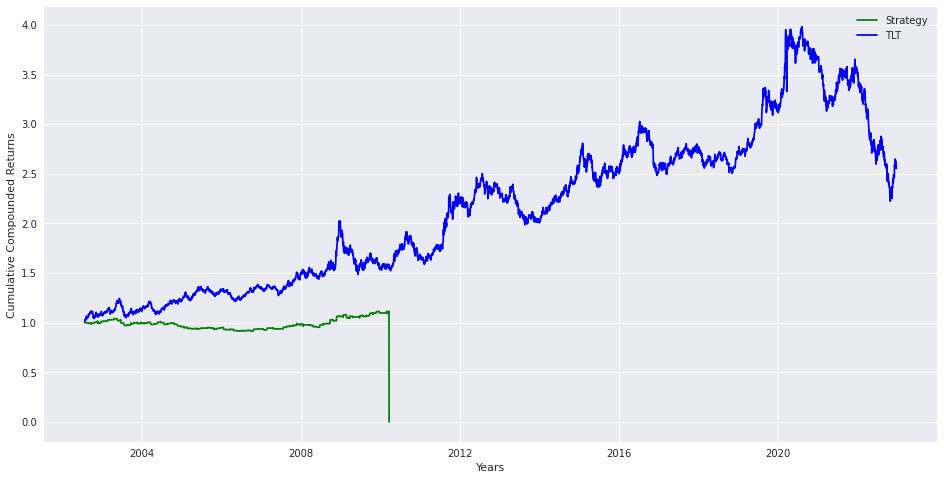

In [230]:
plt.style.use("seaborn")
plt.figure(figsize = (16, 8))
plt.plot(df.index, df["equity_cr"], c = "g", label = "Strategy")
plt.plot(df.index, df["TLT_cr"], c = "b", label = "TLT")
plt.xlabel("Years")
plt.ylabel("Cumulative Compounded Returns")
plt.legend()

In [231]:
# Annualized sharpe ratios:

df["TLT_sharpe"] = (df["TLT_pc"].rolling(1000).mean() / df["TLT_pc"].rolling(1000).std()) * np.sqrt(252)
df["equity_sharpe"] = (df["equity_pc"].rolling(1000).mean() / df["TLT_pc"].rolling(1000).std()) * np.sqrt(252)

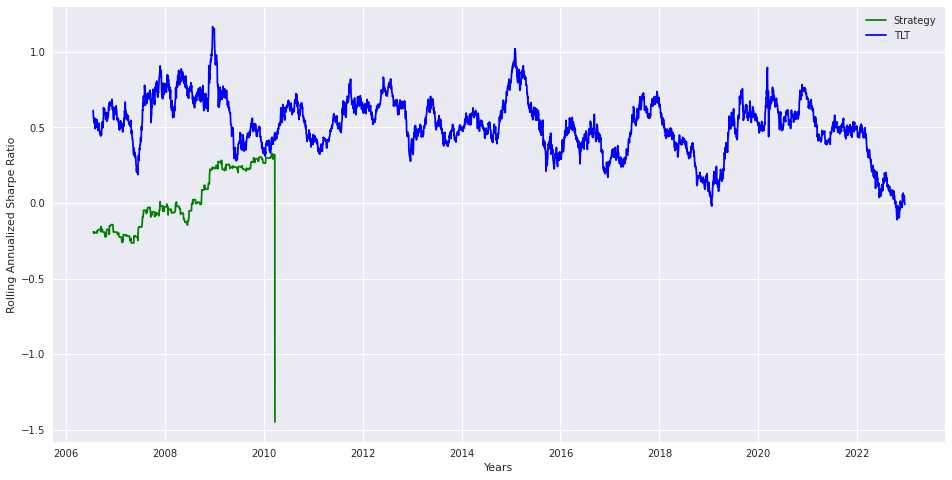

In [232]:
plt.style.use("seaborn")
plt.figure(figsize = (16, 8))
plt.plot(df.index, df["equity_sharpe"], c = "g", label = "Strategy")
plt.plot(df.index, df["TLT_sharpe"], c = "b", label = "TLT")
plt.xlabel("Years")
plt.ylabel("Rolling Annualized Sharpe Ratio")
plt.legend()